# Testing DEMV on _Communities&Crime_ (CRIME) dataset

Data source: [https://archive.ics.uci.edu/ml/datasets/communities+and+crime](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

- Unprivileged group: `black_people=1 && hisp_people=1`
- Positive label: 100

In [12]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [13]:
def prepare_data():
  '''Load the data and apply some pre-processing steps'''
  
  data = pd.read_excel('data2/crime_data_normalized.xlsx', na_values='?')
  data.drop(['state', 'county', 'community', 'communityname',
            'fold', 'OtherPerCap'], axis=1, inplace=True)
  na_cols = data.isna().any()[data.isna().any() == True].index
  data.drop(na_cols, axis=1, inplace=True)
  data = (data - data.mean())/data.std()
  y_classes = np.quantile(data['ViolentCrimesPerPop'].values, [
                          0, 0.2, 0.4, 0.6, 0.8, 1])
  i = 0
  data['ViolentCrimesClass'] = data['ViolentCrimesPerPop']
  for cl in y_classes:
    data.loc[data['ViolentCrimesClass'] <= cl, 'ViolentCrimesClass'] = i*100
    i += 1
  data.drop('ViolentCrimesPerPop', axis=1, inplace=True)
  data['black_people'] = data['racepctblack'] > -0.45
  data['hisp_people'] = data['racePctHisp'] > -0.4
  data['black_people'] = data['black_people'].astype(int)
  data['hisp_people'] = data['hisp_people'].astype(int)
  data.drop('racepctblack', axis=1, inplace=True)
  data.drop('racePctHisp', axis=1, inplace=True)
  return data


In [14]:
data = prepare_data()

In [15]:
data

,population,householdsize,racePctWhite,racePctAsian,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesClass,black_people,hisp_people
0,1.043350,-0.814793,0.599427,-0.161248,-0.542654,-0.166244,-0.277853,-0.575741,1.059815,0.682833,...,-0.193271,-0.580608,-0.058165,0.500363,0.133666,0.167274,0.940163,300.0,0,1
1,-0.453823,-1.853172,-0.056205,1.418626,-1.058133,0.669623,0.082497,-0.854782,-0.343627,0.682833,...,-1.075534,-0.131778,-0.663550,-0.413220,-0.555677,1.258716,-0.391349,500.0,1,1
2,-0.453823,-0.265063,-0.793790,0.078127,-0.220481,-0.166244,-0.337911,-0.575741,-0.499564,-1.565315,...,0.027294,0.217312,-0.461755,-0.504578,-0.112528,-0.618564,-0.391349,500.0,1,0
3,-0.138629,1.872776,-2.760686,-0.161248,0.552737,0.042723,0.022439,-1.189630,-0.031751,0.682833,...,1.074981,0.067702,-0.007717,-0.413220,0.773770,0.516536,-0.391349,300.0,1,1
4,-0.375024,0.528992,0.804312,-0.304873,-0.284915,-0.793144,-0.638204,-0.352509,-0.343627,0.458018,...,0.578708,-0.081908,-0.613101,-0.230503,-0.703394,-0.618564,-0.391349,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.375024,-0.387225,0.476496,-0.161248,0.037258,0.112378,0.082497,-0.687357,-0.265658,0.682833,...,-1.075534,-0.730218,-1.319383,-0.504578,0.232143,-0.487591,-0.391349,200.0,1,1
1990,-0.059830,3.033317,-1.941146,3.237874,1.712562,2.550324,2.364717,-1.580287,-0.031751,0.682833,...,-2.012937,-2.625277,-3.286882,-0.413220,0.675293,0.167274,-0.391349,500.0,1,1
1991,0.806954,-0.570468,-0.261090,-0.544248,-0.478220,0.042723,-0.157736,0.652037,0.825908,0.682833,...,0.413284,0.815752,0.547219,0.134930,0.429099,0.079959,3.395139,400.0,1,1
1992,0.176566,0.284667,0.476496,0.317502,1.003780,1.714457,1.764133,-0.073469,0.202156,0.682833,...,0.027294,-0.181648,-0.663550,-0.321862,0.724532,0.734824,0.524066,300.0,0,1


In [16]:
label = 'ViolentCrimesClass'
groups_condition = {'black_people': 1, 'hisp_people': 1}
sensitive_features = ['black_people', 'hisp_people']
positive_label = 100

In [17]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(n_jobs=-1))
])

## Logistic Regression Bias

In [18]:
model, lr_bias = cross_val(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [19]:
print_metrics(lr_bias)

Statistical parity:  -0.339  +-  0.048
Disparate impact:  0.09  +-  0.063
Zero one loss:  0.209  +-  0.067
F1 score:  0.487  +-  0.03
Accuracy score:  0.497  +-  0.027


## DEMV application

In [20]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression DEMV

In [21]:
model, lr_demv = cross_val(pipeline, demv_data, label, groups_condition, sensitive_features, debiaser=demv, positive_label=100)
print_metrics(lr_demv)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Statistical parity:  -0.202  +-  0.055
Disparate impact:  0.367  +-  0.151
Zero one loss:  0.16  +-  0.063
F1 score:  0.437  +-  0.037
Accuracy score:  0.444  +-  0.035


In [22]:
print_metrics(lr_demv)

Statistical parity:  -0.202  +-  0.055
Disparate impact:  0.367  +-  0.151
Zero one loss:  0.16  +-  0.063
F1 score:  0.437  +-  0.037
Accuracy score:  0.444  +-  0.035


## DEMV Evaluation

In [23]:
demv.get_iters()

164

In [24]:
metrics = eval_demv(42, 164, data.copy(), pipeline, label, groups_condition, sensitive_features, positive_label=100)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing

In [25]:
data = data.sample(frac=1).reset_index(drop=True)

In [26]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, groups_condition, sensitive_features, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.1714  0.7561
200.0  0.0851  0.3529
300.0  0.1839  0.2917
400.0  0.1340  0.4286
500.0  0.0313  0.6000

1
          fpr     tpr
100.0  0.0506  0.9000
200.0  0.0494  0.2500
300.0  0.1714  0.4737
400.0  0.1667  0.5172
500.0  0.1667  0.5652


And loss is 0.4650


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.1774  0.7632
200.0  0.0714  0.3750
300.0  0.1948  0.2609
400.0  0.1333  0.4000
500.0  0.0345  0.6154

1
          fpr     tpr
100.0  0.0563  0.8889
200.0  0.0548  0.1429
300.0  0.1875  0.4375
400.0  0.1698  0.5185
500.0  0.1525  0.5714


And loss is 0.4722

[5.24972593e-01 1.70016236e-01 2.91954298e-10 1.04959399e-01
 2.00051771e-01]
[1.28980336e-01 5.09849965e-01 3.51116700e-10 3.12019048e-01
 4.91506510e-02]
[0.1794509  0.27440658 0.00931677 0.34732422 0.18950153]
[1.37579025e-01 2.60570757e-01 3.13171887e-10 5.49422858e-01
 5.24273610e-02]
[5.94447829e-10 7.72190483e-02 4.39560426e-02 3.07396337e-0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2368  0.8611
200.0  0.0769  0.0952
300.0  0.1889  0.2727
400.0  0.1087  0.2000
500.0  0.0909  0.6154

1
          fpr     tpr
100.0  0.0133  0.5385
200.0  0.1026  0.3000
300.0  0.2241  0.5000
400.0  0.1884  0.7368
500.0  0.0278  0.7500


And loss is 0.4900


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2273  0.8438
200.0  0.0750  0.1111
300.0  0.1875  0.2222
400.0  0.1250  0.1667
500.0  0.0930  0.6667

1
          fpr     tpr
100.0  0.0141  0.6364
200.0  0.0959  0.3333
300.0  0.2075  0.5172
400.0  0.1846  0.7059
500.0  0.0303  0.7500


And loss is 0.4833

[5.90380197e-01 1.83326636e-01 2.05637819e-01 2.06553456e-02
 2.06643931e-09]
[3.49854939e-01 3.44207917e-01 1.77415002e-01 1.28522139e-01
 3.08105065e-09]
[0.15549109 0.18604375 0.52594402 0.07344122 0.05907992]
[0.07774555 0.20460762 0.23544598 0.09180153 0.39039933]
[5.11156265e-09 5.57928749e-02 2.47734337e-01 2.75404605e-02
 6.68932322e-01]
[5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.3038  0.7317
200.0  0.0625  0.1667
300.0  0.1633  0.3182
400.0  0.1386  0.1053
500.0  0.0943  0.5000

1
          fpr     tpr
100.0  0.0571  0.4000
200.0  0.0725  0.0909
300.0  0.1905  0.4706
400.0  0.1803  0.5789
500.0  0.1228  0.7391


And loss is 0.5450


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2899  0.7368
200.0  0.0575  0.2000
300.0  0.1609  0.3000
400.0  0.1429  0.1250
500.0  0.0851  0.5385

1
          fpr     tpr
100.0  0.0476  0.4000
200.0  0.0645  0.0909
300.0  0.1897  0.5333
400.0  0.2000  0.6111
500.0  0.1111  0.7368


And loss is 0.5278

[0.54605026 0.296055   0.06008685 0.0694473  0.02836059]
[0.48169434 0.36830566 0.05589682 0.05277995 0.04132324]
[0.18526705 0.11473295 0.25294721 0.15833984 0.28871295]
[0.09263353 0.03236647 0.13974204 0.13194986 0.6033081 ]
[1.42331074e-12 1.18631079e-12 1.68341928e-01 1.21799874e-01
 7.09858199e-01]
[0.54605026 0.12370952 0.0948552  0.12073117

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2838  0.8571
200.0  0.0825  0.1053
300.0  0.1000  0.2500
400.0  0.0800  0.2500
500.0  0.0753  0.6957

1
          fpr     tpr
100.0  0.0519  0.5714
200.0  0.0145  0.2000
300.0  0.3651  0.4762
400.0  0.2105  0.2963
500.0  0.0857  0.9286


And loss is 0.5000


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2923  0.8537
200.0  0.0682  0.1111
300.0  0.1064  0.2500
400.0  0.0667  0.2500
500.0  0.0805  0.7368

1
          fpr     tpr
100.0  0.0588  0.5000
200.0  0.0167  0.2143
300.0  0.3571  0.5000
400.0  0.1961  0.2609
500.0  0.0984  0.9231


And loss is 0.4944

[1.48592110e-01 7.56683986e-01 9.47239033e-02 2.64067738e-11
 1.02089868e-12]
[1.16043362e-01 6.25854796e-01 2.58101842e-01 2.73889927e-11
 2.63544649e-12]
[7.25271015e-02 3.21714803e-01 4.39091429e-01 9.38924994e-12
 1.66666667e-01]
[2.17581304e-02 2.21514441e-01 4.44227429e-01 2.48720903e-11
 3.12500000e-01]
[1.12737746e-12 1.70031756e-12 2.63157

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2174  0.7750
200.0  0.1348  0.2000
300.0  0.1319  0.2222
400.0  0.0745  0.2000
500.0  0.0860  0.8125

1
          fpr     tpr
100.0  0.0375  0.5000
200.0  0.0633  0.2727
300.0  0.2464  0.3810
400.0  0.2985  0.3913
500.0  0.1077  0.5200


And loss is 0.5327


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2222  0.8056
200.0  0.1098  0.1176
300.0  0.1481  0.2222
400.0  0.0805  0.1667
500.0  0.0843  0.8125

1
          fpr     tpr
100.0  0.0141  0.5556
200.0  0.0571  0.3000
300.0  0.2742  0.4444
400.0  0.3051  0.3810
500.0  0.0690  0.5455


And loss is 0.5196

[0.46147021 0.03173423 0.24894699 0.09251367 0.1653349 ]
[0.3032786  0.06720191 0.20088183 0.17848996 0.25014771]
[0.12730213 0.06346847 0.2526386  0.16904261 0.3875482 ]
[0.0477383  0.07140203 0.02064304 0.18495564 0.675261  ]
[1.30451575e-11 1.78505063e-02 7.28996628e-11 4.83985061e-02
 9.33750988e-01]
[4.61470211e-01 3.16307567e-01 1.26319300e-0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.3636  0.8438
200.0  0.0659  0.1111
300.0  0.0366  0.2222
400.0  0.0659  0.4444
500.0  0.1158  0.8571

1
          fpr     tpr
100.0  0.0964  0.7143
200.0  0.1447  0.1429
300.0  0.1912  0.5000
400.0  0.1324  0.4091
500.0  0.1077  0.6000


And loss is 0.5126


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.3714  0.8276
200.0  0.0732  0.1176
300.0  0.0267  0.2500
400.0  0.0610  0.4118
500.0  0.1149  0.9167

1
          fpr     tpr
100.0  0.0933  0.8000
200.0  0.1324  0.1667
300.0  0.1864  0.4762
400.0  0.1525  0.4286
500.0  0.1186  0.5714


And loss is 0.5140

[0.71022065 0.11736556 0.08960004 0.04984723 0.03296653]
[0.75722054 0.1251324  0.0703358  0.02565905 0.02165221]
[0.25030346 0.04136321 0.21871583 0.32083595 0.16878155]
[0.15144411 0.02502648 0.10394859 0.42857143 0.29100939]
[0.07151527 0.01181806 0.10135157 0.24388653 0.57142857]
[7.10220648e-01 1.78074592e-01 1.11704760e-01 7.37526875e-11
 5.2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2658  0.8000
200.0  0.0816  0.2381
300.0  0.1290  0.3846
400.0  0.0700  0.3684
500.0  0.0660  0.7692

1
          fpr     tpr
100.0  0.0270  0.6667
200.0  0.0870  0.0000
300.0  0.2787  0.3684
400.0  0.1864  0.4762
500.0  0.0702  0.8261


And loss is 0.4774


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2857  0.8056
200.0  0.0805  0.2632
300.0  0.1205  0.3913
400.0  0.0562  0.4118
500.0  0.0632  0.7273

1
          fpr     tpr
100.0  0.0149  0.6667
200.0  0.0952  0.0000
300.0  0.2679  0.3529
400.0  0.2037  0.4737
500.0  0.0769  0.8095


And loss is 0.4749

[7.89553760e-01 9.84715549e-02 8.33333333e-02 2.86413515e-02
 7.63517559e-12]
[0.46427481 0.23453241 0.15789474 0.05243766 0.09086039]
[0.34091677 0.11776189 0.39130435 0.04164952 0.10836747]
[0.11531008 0.01025121 0.23529412 0.09775031 0.54139428]
[8.91032457e-02 4.52650940e-03 1.37201432e-10 6.87199341e-02
 8.37650311e-01]
[7.89553760e-01 8.24763

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2051  0.7097
200.0  0.0706  0.2500
300.0  0.1573  0.4500
400.0  0.1158  0.4286
500.0  0.0674  0.6500

1
          fpr     tpr
100.0  0.0750  0.5000
200.0  0.0779  0.3846
300.0  0.1831  0.4737
400.0  0.1940  0.5652
500.0  0.0462  0.6800


And loss is 0.4724


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2083  0.7143
200.0  0.0641  0.2273
300.0  0.1707  0.3889
400.0  0.1264  0.3846
500.0  0.0741  0.6316

1
          fpr     tpr
100.0  0.0563  0.5000
200.0  0.0746  0.4167
300.0  0.1935  0.5294
400.0  0.2105  0.5909
500.0  0.0339  0.6500


And loss is 0.4804

[6.52120010e-01 2.05022848e-01 5.51294342e-02 8.77277087e-02
 9.52742674e-12]
[4.56484007e-01 2.70788721e-01 8.77059181e-02 1.85021355e-01
 5.33814632e-11]
[0.15216134 0.07006089 0.15007457 0.40548098 0.22222222]
[0.07022831 0.00669477 0.1484254  0.62080537 0.15384615]
[1.15779431e-11 1.01116661e-11 1.80360851e-11 3.68421052e-01
 6.31578948e-01]
[0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2533  0.8529
200.0  0.0920  0.3182
300.0  0.0899  0.4000
400.0  0.0918  0.0909
500.0  0.0460  0.7273

1
          fpr     tpr
100.0  0.0625  0.2000
200.0  0.1111  0.2222
300.0  0.2714  0.4000
400.0  0.2167  0.4000
500.0  0.1014  0.6190


And loss is 0.5075


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2424  0.8788
200.0  0.0750  0.3684
300.0  0.0732  0.4706
400.0  0.0899  0.1000
500.0  0.0506  0.7000

1
          fpr     tpr
100.0  0.0704  0.2222
200.0  0.0972  0.2500
300.0  0.2742  0.3889
400.0  0.2222  0.3846
500.0  0.1148  0.5789


And loss is 0.4916

[0.15863516 0.58866343 0.04184562 0.1615325  0.04932328]
[0.09500836 0.68468045 0.03812998 0.13728928 0.04489193]
[0.02123716 0.24716386 0.13475364 0.41061092 0.18623441]
[0.03610318 0.12017857 0.11720547 0.38461539 0.34189739]
[0.01805159 0.11008929 0.04999559 0.24291617 0.57894737]
[1.58635161e-01 6.61693317e-01 1.79671515e-01 6.59814117e-09
 8.8

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2000  0.7692
200.0  0.1748  0.1053
300.0  0.1389  0.4286
400.0  0.0784  0.4500
500.0  0.0190  0.4706

1
          fpr     tpr
100.0  0.0533  0.5000
200.0  0.0435  0.2500
300.0  0.2500  0.4800
400.0  0.2542  0.1667
500.0  0.1887  0.5833


And loss is 0.5126


Pre-adjustment group rates are 

0
          fpr     tpr
100.0  0.2097  0.7708
200.0  0.1739  0.1111
300.0  0.1443  0.4615
400.0  0.0659  0.4211
500.0  0.0204  0.5000

1
          fpr     tpr
100.0  0.0448  0.5000
200.0  0.0492  0.2500
300.0  0.2400  0.4211
400.0  0.2692  0.1765
500.0  0.2174  0.5652


And loss is 0.5196

[3.85640545e-01 4.16666653e-02 2.11776204e-01 1.01265375e-08
 3.60916575e-01]
[2.77939132e-01 3.33333303e-01 1.31378813e-01 9.45487836e-09
 2.57348742e-01]
[3.84838841e-02 4.61538419e-01 2.76779089e-01 1.17572935e-08
 2.23198596e-01]
[5.26621553e-02 2.10526298e-01 1.45949403e-01 1.24989402e-08
 5.90862130e-01]
[4.77718787e-09 1.66666654e-01 7.19582

##  Plot

In [27]:
df = prepareplots(metrics,'crime')

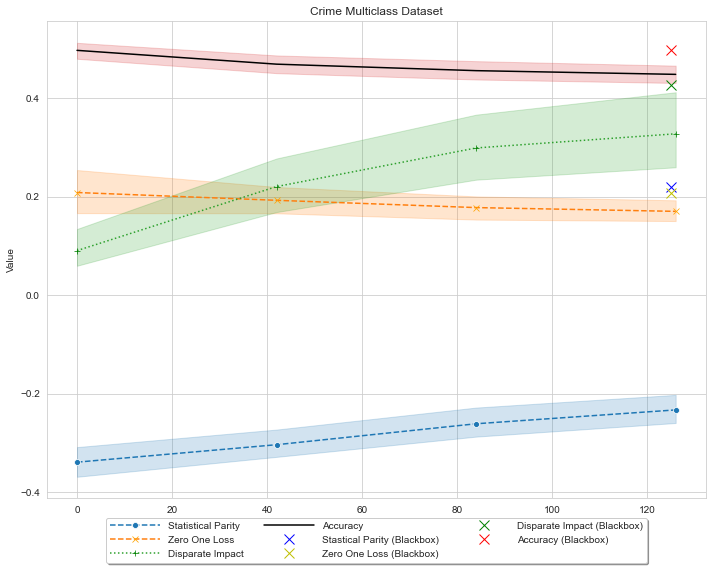

In [28]:
points = preparepoints(blackboxmetrics, 125)

plot_metrics_curves(df, points, title='Crime Multiclass Dataset')


In [29]:
unprivpergentage(data,groups_condition, demv.get_iters())

Dataset size: 1994
Unprivileged group size: 471
Percentage of unprivileged group: 23.620862587763288
Number of iterations: 164


In [30]:
save_metrics('blackbox', 'crime', blackboxmetrics)